In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

from matplotlib import pyplot as plt
from geomloss import SamplesLoss
from tqdm import tqdm

from utils import Synthetic
from differentiable_rendering.sigmoids_renderer.renderer import Renderer

In [3]:
def compute_pixel_coords(image):
    return np.argwhere(image)


def compute_pixel_density(image):
    pixel_density = image[np.nonzero(image)]
    pixel_density /= np.sum(pixel_density)
    return pixel_density


def shift_lines(lines, dx=0, dy=0):
    new_masses = []
    
    for mass in lines:
        mass = list(mass)
        
        mass[0] += dx
        mass[2] += dx
        
        mass[1] += dy
        mass[3] += dy
        
        new_masses.append(tuple(mass))
            
    return new_masses

In [4]:
def visualize(renderer, image, line_batch, render_label):
    render = renderer.render(line_batch)[0].detach().cpu().numpy()
    x, y = np.nonzero(render)
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gist_gray')
    plt.scatter(x, y, cmap='gist_gray', label=render_label, alpha=0.5)
    plt.legend()
    plt.show()

In [5]:
DEFAULT_LOSS = SamplesLoss("sinkhorn", p=2, blur=.01)
DEFAULT_RENDERER = Renderer((64, 64), linecaps='butt', dtype=torch.float32)

def optimize_line_batch(line_batch, raster_coords, raster_masses, n_iters=50,
                        lr=0.2, loss=DEFAULT_LOSS, renderer=DEFAULT_RENDERER, verbose=True):
    
    vector_coords = torch.from_numpy(np.mgrid[0:64, 0:64].reshape(2, -1).T.astype(np.float32))
    
    iter_range = range(n_iters)
    if verbose:
        iter_range = tqdm(iter_range)
        
    line_batch.requires_grad_()
        
    for _ in iter_range:
    
        vector_masses = renderer.render(line_batch)[0]
        vector_masses = (vector_masses / vector_masses.sum()).flatten()
        
        if line_batch.grad is not None:
            line_batch.grad.data.zero_()
    
        sample_loss = loss(vector_masses, vector_coords, raster_masses, raster_coords)
        sample_loss.backward()
        
        g_line_batch = line_batch.grad.data
        line_batch.data -= lr * g_line_batch
        
    return line_batch


def get_pixel_coords_and_density(image):
    pixel_coords = compute_pixel_coords(image)
    pixel_density = compute_pixel_density(image)
    
    torch_pixel_coords = torch.from_numpy(pixel_coords.astype(np.float32))
    torch_pixel_density = torch.from_numpy(pixel_density.astype(np.float32))
    
    return torch_pixel_coords, torch_pixel_density

One line transport:

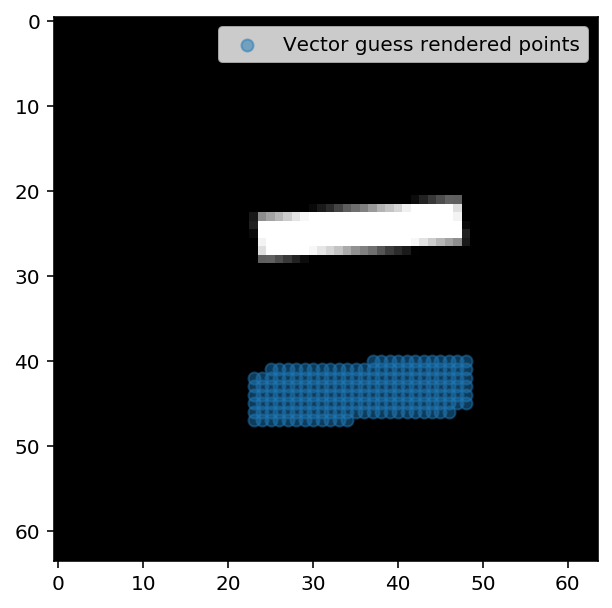

100%|██████████| 50/50 [02:10<00:00,  2.60s/it]


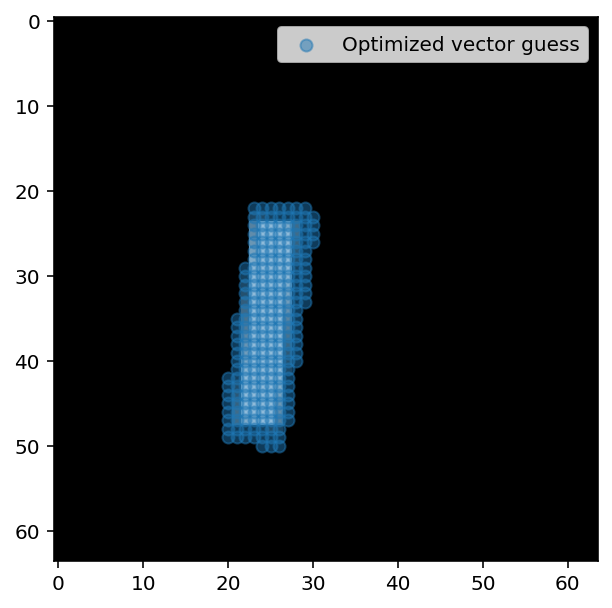

In [6]:
s = Synthetic(64, 64)
# random seed 111, line_batch = np.array([[[45., 24., 43., 48., 5., 0.5]]]).astype(np.float32), lr 0.5
np.random.seed(111)

image, _ = s.get_image('.', line_count=1)
image = 1 - np.array(image) / 255

raster_coords, raster_masses = get_pixel_coords_and_density(image)

line_batch = np.array([[[45., 24., 43., 48., 5., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)

visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')

line_batch = optimize_line_batch(line_batch, raster_coords, raster_masses, lr=0.5)
visualize(DEFAULT_RENDERER, image.T, line_batch, 'Optimized vector guess')

The second picture is transposed.

Another one-line transport:

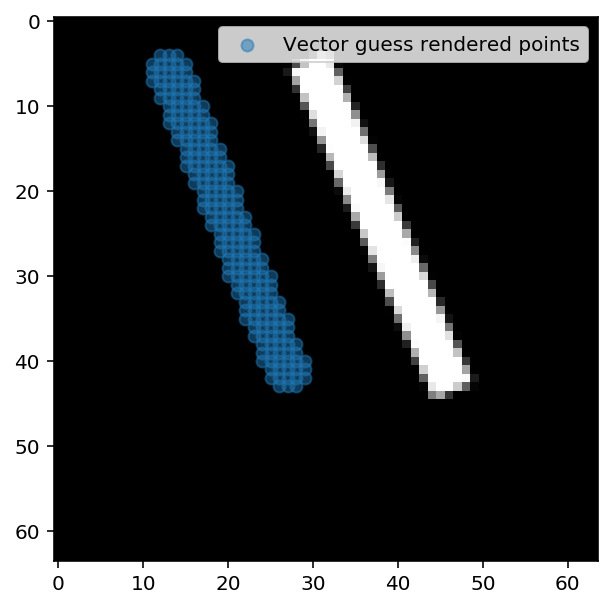

100%|██████████| 70/70 [03:00<00:00,  2.57s/it]


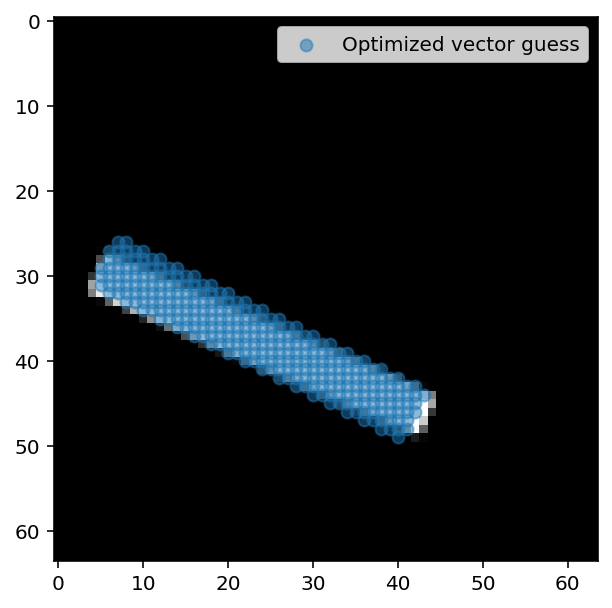

In [7]:
s = Synthetic(64, 64)
np.random.seed(112)

image, _ = s.get_image('.', line_count=1)
image = 1 - np.array(image) / 255

raster_coords, raster_masses = get_pixel_coords_and_density(image)

line_batch = np.array([[[5., 13., 43., 28., 3., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)

visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')

line_batch = optimize_line_batch(line_batch, raster_coords, raster_masses, n_iters=70, lr=0.2)
visualize(DEFAULT_RENDERER, image.T, line_batch, 'Optimized vector guess')

## More lines

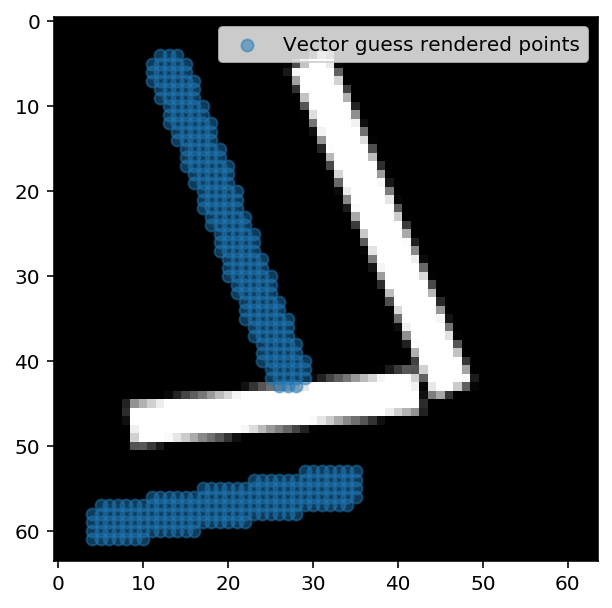

100%|██████████| 70/70 [03:11<00:00,  2.74s/it]


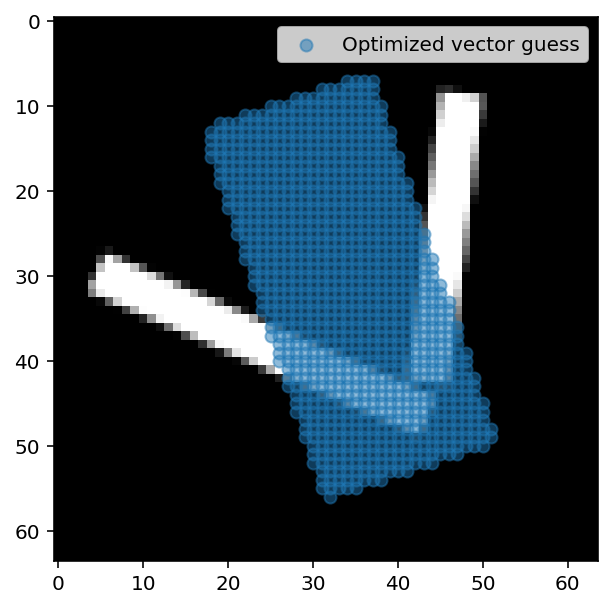

In [8]:
s = Synthetic(64, 64)
# random seed 111, line_batch = np.array([[[45., 24., 43., 48., 5., 0.5]]]).astype(np.float32), lr 0.5
np.random.seed(112)

image, _ = s.get_image('.', line_count=2)
image = 1 - np.array(image) / 255

raster_coords, raster_masses = get_pixel_coords_and_density(image)

line_batch = np.array([[[5., 13., 43., 28., 3., 0.5], [60., 5., 55., 35., 3., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)

visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')

line_batch = optimize_line_batch(line_batch, raster_coords, raster_masses, n_iters=70, lr=0.2)
visualize(DEFAULT_RENDERER, image.T, line_batch, 'Optimized vector guess')

The result is quite expected — we have to control the total pixel mass in the rendering to be constant (or at least make changes of mass cost a lot).
